# Matched Discrimination Analysis

In [2]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.linear_model import LinearRegression


## Load in data if pipeline has already been run through

In [18]:
_dir = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_discrimination'
# raw_dir = _dir + '/data/finalVEMatched/raw/'
zs_dir = _dir + '/data/finalDiscrimMatched/z_scored_RT/'

# final_data = pd.read_csv (raw_dir + '/raw_discrim.csv')
zscored_data = pd.read_csv (zs_dir + 'final_discrim.csv')

In [6]:
def combineCSVs(datafolder, num_discrim_trials):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    
    returns:
        (1) combined dataframe of all discrimination data 
        (2) combined dataframe of all scene property rating data 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        discrim_data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                df_discrim = df[0:num_discrim_trials]
                discrim_data.append(df_discrim)

        discrim_frame = pd.concat(discrim_data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            df = pd.read_csv(datafolder, index_col=None, header=0)
            df_discrim = df[0:num_discrim_trials]
            discrim_data.append(df_discrim)
 
    return discrim_frame

In [7]:
data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_discrimination_MTurk/data'
num_total_trials = 86

In [9]:
raw_discrim = combineCSVs(data_path, num_total_trials)

In [10]:
# raw_discrim

In [12]:
all_subjIDs = raw_discrim.subjID.unique()
len(all_subjIDs)

453

In [13]:
all_ages = raw_discrim.age.unique()
all_ages

array([  24,   28,   45,   33,   35,   55,   32,   58,   29,   46,   42,
         48,   37,   25,   64,   31,   22,   27,   70,   57,   36, 1994,
         38,   56,   52,   59,   44,   34,   40,   47,   30,   62,   43,
         50,   49, 1990,   61,   39,   53,   63,   54,   26,   51, 1971,
         67,   41,   60,   66, 1980,   77,   65,   76,   68, 1964, 1966,
       1959,   69, 1973])

## <font color='red'> Data Cleaning </font> 



In [20]:
def catchTrial_cleaning(df, correct_requirement, catch_stimuli):
    '''
    Participants complete 8 catch trials total to ensure that they are doing the task.
    If less than 6/8 catch trials are correct, the participant is excluded.  
    '''
    all_subjIDs = df.subjID.unique()
    remove = []
    subj_sequence = {}
    df2_list = []
    
    for subj in all_subjIDs:
        count_correct = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        # 
        subj_sequence[subj] = subj_df.sequenceName.unique()[0]
        
        # remove trials that are outside the outlier range
        c = 0
        c_missed = 0
        for idx, row in subj_df.iterrows():
            stim1 = row['stimulus_0']
            stim2 = row['stimulus_1']
            # TEMP SOLUTION FOR RANDOM PHP DATA SAVING PROBLEM 
            if type(stim1) == str:
                if stim1.split('/')[1] in catch_stimuli or stim2.split('/')[1] in catch_stimuli:
                    ####### VERSION WHERE CATCH TRIALS ARE ATTENTION CHECK: IMAGE 1 IS THE SAME AS IMAGE 2
                    c += 1
                    if row["discrim_choice"] == 3:
#                         print(row["discrim_choice"])
                        count_correct += 1
#                     else:
#                         print(row["discrim_choice"])
                    # remove catch trial 
                    cleaned_subj_df.drop([idx], inplace=True)
    #                 print(depth0, depth1, correct_choice, choice)
#         print(c_missed, 'Number of catch trials where participants did not see the target')
#         print(c)
#         print(count_correct)
        if count_correct < correct_requirement:
#             print('Number correct:', count_correct)
            remove.append(subj)

        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))
    print("Participants that were removed:",remove)
#     print("Sequences that need to be replaced:")
#     for subj in remove:
#         print(subj_sequence[subj])
#     print("Sequence count:")
#     print(sequence_count)
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2
    
    

In [17]:
sequences_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_discrimination_MTurk/discrim_jsons'
sequences_count_dict = {}
for seq in os.listdir(sequences_path):
    if 'json' in seq:
        sequences_count_dict['discrim_jsons/'+seq] = 0


In [18]:
all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
                  '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
                  '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
                  '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
                  '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
                  '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
                  '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
                  '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

In [21]:
catch_cleaned_discrim = catchTrial_cleaning(raw_discrim, 6, all_catch_stim)

Number of participants that did not pass the catch trial check: 240
Participants that were removed: [207145.0, 359804.0, 791018.0, 537018.0, 799422.0, 997276.0, 700672.0, 475223.0, 129454.0, 690228.0, 974004.0, 721593.0, 195085.0, 575281.0, 265944.0, 742722.0, 651627.0, 765779.0, 366587.0, 528446.0, 500865.0, 656215.0, 550139.0, 794960.0, 522960.0, 950356.0, 870217.0, 606405.0, 862413.0, 263688.0, 973693.0, 884246.0, 628476.0, 760636.0, 465665.0, 625113.0, 952619.0, 561228.0, 797153.0, 643684.0, 526824.0, 553428.0, 821092.0, 845545.0, 858936.0, 586345.0, 506068.0, 370949.0, 648386.0, 789933.0, 602014.0, 752319.0, 842328.0, 412938.0, 518960.0, 380019.0, 501569.0, 146553.0, 725052.0, 179461.0, 546300.0, 631733.0, 980291.0, 540829.0, 670033.0, 722241.0, 437734.0, 436146.0, 358938.0, 479413.0, 335826.0, 508146.0, 640494.0, 598714.0, 108769.0, 238979.0, 809413.0, 674192.0, 656089.0, 284413.0, 406583.0, 230216.0, 247366.0, 757677.0, 195791.0, 584352.0, 454741.0, 163516.0, 542949.0, 129379.0,

In [22]:
cleaned_ages = catch_cleaned_discrim.age.unique()
cleaned_ages

array([  28,   45,   33,   35,   58,   29,   42,   37,   25,   31,   22,
         46,   24,   36,   38,   52,   44,   40,   47,   27,   43,   62,
         49,   50,   64,   70,   53,   63,   30,   32,   57,   56,   26,
         34,   39,   67,   41,   55,   60,   59,   66, 1980,   77,   76,
         51,   69,   61,   54,   48,   68])

In [169]:
def RT_cleaning(df, outlier_range, num_trials):
    all_subjIDs = df.subjID.unique()
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        
        # calculate subject's average trial RT
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
        
        # remove trials that are outside the outlier range
        for idx, row in subj_df.iterrows():
            RT = row['trial_RT']
            if RT < outlier_range[0]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of Participants with 10% or more trials outside their RT range:", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2


In [170]:
cleaned_discrim = RT_cleaning(catch_cleaned_discrim, [250,10000], 78)



Number of Participants with 10% or more trials outside their RT range: 9


In [167]:
def finalTrialCountCheck(df, num_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column\n",
    all_subjIDs = df.subjID.unique()
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)
        
        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
    print("Number of Participants with >= 10% trials removed:", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    
    print("Number of participants left:",len(df.subjID.unique()))
    
    return df

In [168]:
final_discrim = finalTrialCountCheck(cleaned_discrim, 78)

Number of Participants with >= 10% trials removed: 0
Number of participants left: 143


In [27]:
final_discrim

,subjID,workerId,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,...,trial_RT,log_fixation,log_sceneDuration1,log_mask1,log_sceneDuration2,log_mask2,experimentTime,totalTime,age,gender
86,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,1600.0,...,1413.0,1014.0,247.0,992.0,253.0,496.0,NaN,475685,28,Man
87,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,1600.0,...,1180.0,1003.0,262.0,998.0,253.0,486.0,NaN,475685,28,Man
88,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,1600.0,...,1094.0,1015.0,248.0,1002.0,248.0,500.0,NaN,475685,28,Man
89,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,1600.0,...,1233.0,1012.0,250.0,1000.0,254.0,487.0,NaN,475685,28,Man
90,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,1600.0,...,1196.0,1016.0,234.0,1000.0,265.0,498.0,NaN,475685,28,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38695,738393.0,A324M5ZRHX7RUV,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_37_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,19.0,1600.0,749.0,1600.0,...,1122.0,1005.0,249.0,1004.0,257.0,490.0,NaN,379220,28,Woman
38696,738393.0,A324M5ZRHX7RUV,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_37_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,19.0,1600.0,749.0,1600.0,...,1045.0,1006.0,250.0,1000.0,248.0,500.0,NaN,379220,28,Woman
38697,738393.0,A324M5ZRHX7RUV,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_37_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,19.0,1600.0,749.0,1600.0,...,1101.0,1015.0,239.0,998.0,248.0,513.0,NaN,379220,28,Woman
38698,738393.0,A324M5ZRHX7RUV,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_37_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,19.0,1600.0,749.0,1600.0,...,1107.0,1013.0,249.0,997.0,251.0,499.0,NaN,379220,28,Woman


### Z-Score RT 

In [15]:
def zscored_outcomes(df):
    '''
    z-score RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        # Z-Score RT
        stimulus_duration = subj_df.log_sceneDuration2.unique()[0]
        average_RT = subj_df["trial_RT"].mean()
        std_RT = subj_df["trial_RT"].std()
        # remove stimulus duration and mask time
        subj_RTs = np.array(list(subj_df["trial_RT"])) - (stimulus_duration+500)
        
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.insert(12, "z_scored_RT", zscored_subj_RTs, True)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2
     

In [16]:
zscored_data = zscored_outcomes(final_discrim)

/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


In [174]:
# sequences that are completed

sampled_urls = zscored_data.url.unique()


<!-- ## Sequences that need replacing

Final N = 192 

Each sequence should have 48 participants -->

In [175]:
# sampled_urls

In [177]:
# final list of subjects 
# zscored_data.subjID.unique()

# Correlation with Verbal Report data 

- For each discrimination trial, get the average difference between the verbal report for those scenes 
- Correlate that with the proportion correct for that trial 
- Is there better accuracy for scenes that have a larger percevied depth difference (using the verbal report data)?

## Individual Discriminations

In [28]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        list_RTs.append(row["trial_RT"])
#         list_RTs.append(row["z_scored_RT"])
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

In [22]:
def depth_differences(df):
    """
    args:
        df  
    returns:
        array of depth differences, avg depth differences and std   
    """
    depth_diffs = []
    answers = []
    for idx, row in df.iterrows():
        depth0 = row["actual_depth_0"]
        depth1 = row["actual_depth_1"]
        
        diff = depth0-depth1
        if diff < 0:
            answer = row['stimulus_0']
        else:
            answer = row['stimulus_1']
        answers.append(answer)
        depth_diffs.append(abs(depth0-depth1))
    
    depth_diffs = np.array(depth_diffs)
    
    return depth_diffs, np.mean(depth_diffs) ,np.std(depth_diffs),answers
    

In [23]:
all_depth_diffs = depth_differences(zscored_data)

# add depth difference column to dataframe 
zscored_data.insert(18, "depth_difference", all_depth_diffs[0])

ValueError: cannot insert depth_difference, already exists

In [24]:
zscored_data.insert(19, "kinect_answer", all_depth_diffs[-1])

ValueError: cannot insert kinect_answer, already exists

In [25]:
final_discrim_125 = zscored_data.loc[zscored_data['duration'] == 125]
final_discrim_250 = zscored_data.loc[zscored_data['duration'] == 250]
final_discrim_1000 = zscored_data.loc[zscored_data['duration'] == 1000]

In [26]:
final_discrim = zscored_data

In [304]:
dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/z_scored_RT'

final_discrim_125.to_csv(dest + '/' + 'final_discrim_125.csv')
final_discrim_250.to_csv(dest + '/' + 'final_discrim_250.csv')
final_discrim_1000.to_csv(dest + '/' + 'final_discrim_1000.csv')
final_discrim.to_csv(dest + '/' + 'final_discrim.csv')

In [29]:
overall_accuracy = get_accuracy(final_discrim)
overall_accuracy

(0.5848045105832332, 6327, 10819, 100)

In [30]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = [elem for elem in df.stimulus_0.unique() if type(elem) == str]

    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
                
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        kinect_answer = stim0_df.kinect_answer.unique()[0]
        
        try:
            stim_acc_125 = get_accuracy(stim_125_df)
            stim_acc_250 = get_accuracy(stim_250_df)
            stim_acc_1000 = get_accuracy(stim_1000_df)

            stim_RT_125 = get_RT(stim_125_df)
            stim_RT_250 = get_RT(stim_250_df)
            stim_RT_1000 = get_RT(stim_1000_df)

            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'RT_125': stim_RT_125,
                                    'accuracy_250': stim_acc_250,
                                    'RT_250': stim_RT_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'RT_1000': stim_RT_1000,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'kinect_answer': kinect_answer}
        except:
            pass
    
    return stimuli_stats

In [31]:
all_discrim_performance = individual_discrimination_stats(zscored_data)


In [308]:
# all_discrim_performance['depth_discrimination_stimuli/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png']



## Load Z-scored TAC Verbal Judgement Data


In [33]:
p = '/Users/pmahableshwarkar/Documents/Depth_Project/verbal_judgement_analysis/data/finalVEMatched/z_scored/'

# x data
with open(p + 'X_125.npy' , 'rb') as f:
    n_TAC_X_125 = np.load(f, allow_pickle=True)
    
with open(p + 'X_250.npy' , 'rb') as f:
    n_TAC_X_250 = np.load(f, allow_pickle=True)

with open(p + 'X_1000.npy' , 'rb') as f:
    n_TAC_X_1000 = np.load(f, allow_pickle=True)
    
# y data 
with open(p + 'z_final_y_125.npy' , 'rb') as f:
    n_TAC_final_y_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_y_250.npy' , 'rb') as f:
    n_TAC_final_y_250 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_y_1000.npy' , 'rb') as f:
    n_TAC_final_y_1000= np.load(f, allow_pickle=True)

# std data
with open(p + 'z_std_125.npy' , 'rb') as f:
    n_TAC_std_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_std_250.npy' , 'rb') as f:
    n_TAC_std_250 = np.load(f, allow_pickle=True)

with open(p + 'z_std_1000.npy' , 'rb') as f:
    n_TAC_std_1000 = np.load(f, allow_pickle=True)
    
# ste data
with open(p + 'z_ste_125.npy' , 'rb') as f:
    n_TAC_ste_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_ste_250.npy' , 'rb') as f:
    n_TAC_ste_250 = np.load(f, allow_pickle=True)

with open(p + 'z_ste_1000.npy' , 'rb') as f:
    n_TAC_ste_1000 = np.load(f, allow_pickle=True)

# stim data
with open(p + 'z_final_stim_125.npy' , 'rb') as f:
    n_TAC_final_stim_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_stim_250.npy' , 'rb') as f:
    n_TAC_final_stim_250 = np.load(f, allow_pickle=True)

with open(p + 'z_final_stim_1000.npy' , 'rb') as f:
    n_TAC_final_stim_1000 = np.load(f, allow_pickle=True)

# Code depth discrimination correctness by the verbal judgement data 

Create new 'ground truth' answer based on verbal judgement data

Task: Respond which image's target was closer to you

## VE Data

In [34]:
n_VE_answerkey_125 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_125 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_125[idx0]
    std0 = n_TAC_std_125[idx0]
    ste0 = n_TAC_ste_125[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_125 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_125[idx1]
    std1 = n_TAC_std_125[idx1]
    ste1 = n_TAC_ste_125[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_125[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}

In [35]:
# n_VE_answerkey_125

In [36]:
n_VE_answerkey_250 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_250 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_250[idx0]
    std0 = n_TAC_std_250[idx0]
    ste0 = n_TAC_ste_250[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_250 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_250[idx1]
    std1 = n_TAC_std_250[idx1]
    ste1 = n_TAC_ste_250[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_250[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [37]:
# len(n_VE_answerkey_250), n_VE_answerkey_250['depth_discrimination_stimuli/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1-target.png']
# n_VE_answerkey_250

In [38]:
n_VE_answerkey_1000 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_1000 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_1000[idx0]
    std0 = n_TAC_std_1000[idx0]

    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_1000 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_1000[idx1]
    std1 = n_TAC_std_1000[idx1]
    
    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]



    n_VE_answerkey_1000[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [39]:
len(n_VE_answerkey_1000)

156

In [316]:
import pickle
# save answer keys as pickle file 

# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_1000.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_1000, handle)

In [317]:
# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_250.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_250, handle)

### VE Coded Accuracy

In [40]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    kinect_correct_answer = answerkey[stim0]['kinect_answer']
    
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0:
            image_choice = row["stimulus_0"]
                
        if choice == 1.0:
            image_choice = row["stimulus_1"]
                
        if choice == 2.0:
            count_missed += 1
            
        if choice == 3.0:
            count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer:
                count_correct += 1
        except:
            pass
        
#     standardError = (0.5*(1-0.5))/count_total
    p = count_correct/count_total
    standardError = np.sqrt((p*(1-p))/count_total)
    
    if VE_correct_answer == kinect_correct_answer:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'pos'
    else:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'neg'

    
def main_VE_accuracy(df, answerkey_125, answerkey_250, answerkey_1000):
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        try:
            # dataframe for stimulus 0
            stim0_df = df.loc[df['stimulus_0'] == stim0]
            # name of stimulus 1
            other_stim = stim0_df.stimulus_1.unique()[0]
            # dataframe where stimulus 0 is presented SECOND (same trial)
            stim1_df = df.loc[df['stimulus_1'] == stim0]

            # df for a specific discrimination trial (collapsed on stim presentation order)
            stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
            stim_125_df = stim_df[stim_df['duration'] == 125.0]
            stim_250_df = stim_df[stim_df['duration'] == 250.0]
            stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 

            stim0_depth = stim_df['actual_depth_0'][0]
            stim1_depth = stim_df['actual_depth_1'][0]
            stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))

            stim_acc_125 = VE_accuracy(stim0, stim_125_df, answerkey_125)
            stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
            stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)

            # difference between verbal judgements divided by joint variance 
            # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
            std0_125 = answerkey_125[stim0]['std0']
            std1_125 = answerkey_125[stim0]['std1']
            joint_variance_125 = np.sqrt(std0_125**2 + std1_125**2)
            JV_regressor_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])/joint_variance_125

            std0_250 = answerkey_250[stim0]['std0']
            std1_250 = answerkey_250[stim0]['std1']
            joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
            JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

            std0_1000 = answerkey_1000[stim0]['std0']
            std1_1000 = answerkey_1000[stim0]['std1']
            joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
            JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
            if stim_acc_125[-1] == 'pos':
                VE_depthdifference_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_125 = -(abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_250[-1] == 'pos':
                VE_depthdifference_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_250 = -(abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_1000[-1] == 'pos':
                VE_depthdifference_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_1000 = -(abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']))
            
            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'accuracy_250': stim_acc_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'avg_depth': stim_depthbin,
                                    'VE_depthdifference_125': VE_depthdifference_125, 
                                    'VE_depthdifference_250': VE_depthdifference_250, 
                                    'VE_depthdifference_1000': VE_depthdifference_1000,
                                    'RT_125': get_RT(stim_125_df),
                                    'RT_250': get_RT(stim_250_df),
                                    'RT_1000': get_RT(stim_1000_df),
                                    'JV_regressor_125': JV_regressor_125,
                                    'JV_regressor_250': JV_regressor_250,
                                    'JV_regressor_1000': JV_regressor_1000,
                                    'kinect_answer_125': answerkey_125[stim0]['kinect_answer'],
                                    'kinect_answer_250': answerkey_250[stim0]['kinect_answer'],
                                    'kinect_answer_1000': answerkey_1000[stim0]['kinect_answer']}
            

        except:
            print(stim0)

    return stimuli_stats
    

In [41]:
n_all_VE_discrim_performance = main_VE_accuracy(zscored_data, n_VE_answerkey_125, n_VE_answerkey_250, n_VE_answerkey_1000) 

nan


In [42]:
len(n_all_VE_discrim_performance)


156

In [321]:
import pickle
# save performance as pickle file 

dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/'
with open(dest + 'performance.pkl', 'wb') as handle:
    pickle.dump(n_all_VE_discrim_performance, handle)
    

In [43]:
n_VE_estim_diff_125 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_125'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_250 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_1000 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in n_all_VE_discrim_performance]

n_VE_accuracy_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in n_all_VE_discrim_performance]

n_VE_ste_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][-2] for elem in n_all_VE_discrim_performance]

n_avg_RT_125 = [n_all_VE_discrim_performance[elem]['RT_125'][1] for elem in n_all_VE_discrim_performance]
n_avg_RT_250 = [n_all_VE_discrim_performance[elem]['RT_250'][1] for elem in n_all_VE_discrim_performance]
n_avg_RT_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][1] for elem in n_all_VE_discrim_performance]

n_avg_RT_ste_125 = [n_all_VE_discrim_performance[elem]['RT_125'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_250 = [n_all_VE_discrim_performance[elem]['RT_250'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][-1] for elem in n_all_VE_discrim_performance]

n_JV_125 = [n_all_VE_discrim_performance[elem]['JV_regressor_125'] for elem in n_all_VE_discrim_performance]
n_JV_250 = [n_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in n_all_VE_discrim_performance]
n_JV_1000 = [n_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in n_all_VE_discrim_performance]

n_kinectanswer_125 = [n_all_VE_discrim_performance[elem]['kinect_answer_125'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_250 = [n_all_VE_discrim_performance[elem]['kinect_answer_250'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_1000 = [n_all_VE_discrim_performance[elem]['kinect_answer_1000'] for elem in n_all_VE_discrim_performance]

n_stim = [elem for elem in n_all_VE_discrim_performance]

#### Overall Accuracy: Coded by Normalized VE


In [44]:
np.mean(n_VE_accuracy_125), np.mean(n_VE_accuracy_250), np.mean(n_VE_accuracy_1000)

(0.6420125943763318, 0.7071999038465697, 0.77160193037672)

In [45]:
print('125 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_125, n_VE_estim_diff_125)

125 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.4100805586648402, 1.0582668650686856e-07)

In [46]:
print('250 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_250, n_VE_estim_diff_250)

250 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.5912401698725099, 4.439953346353006e-16)

In [47]:
print('1000 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_1000, n_VE_estim_diff_1000)

1000 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.6842482481038682, 7.112918887166016e-23)

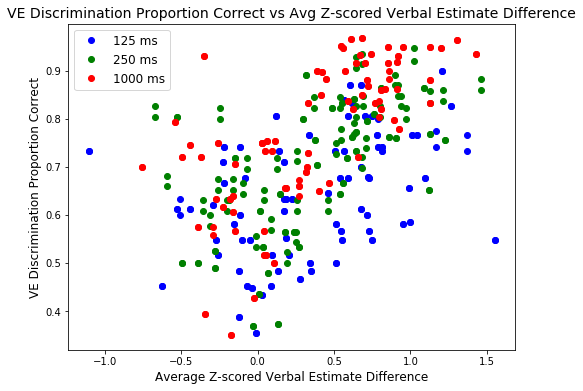

In [327]:
plt.figure(figsize=[8,6])
plt.plot(np.array(n_VE_estim_diff_125), np.array(n_VE_accuracy_125), 'bo', label='125 ms')
plt.plot(np.array(n_VE_estim_diff_250), np.array(n_VE_accuracy_250), 'go', label='250 ms')
plt.plot(np.array(n_VE_estim_diff_1000), np.array(n_VE_accuracy_1000), 'ro', label='1000 ms')
plt.xlabel('Average Z-scored Verbal Estimate Difference', fontsize=12)
plt.ylabel('VE Discrimination Proportion Correct', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('VE Discrimination Proportion Correct vs Avg Z-scored Verbal Estimate Difference', fontsize = 14)
plt.show();

In [328]:
# len(n_VE_accuracy_250)

In [49]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

m: [0.16596754]
b: 0.557255125240084
R-squared:  0.23099618454867354


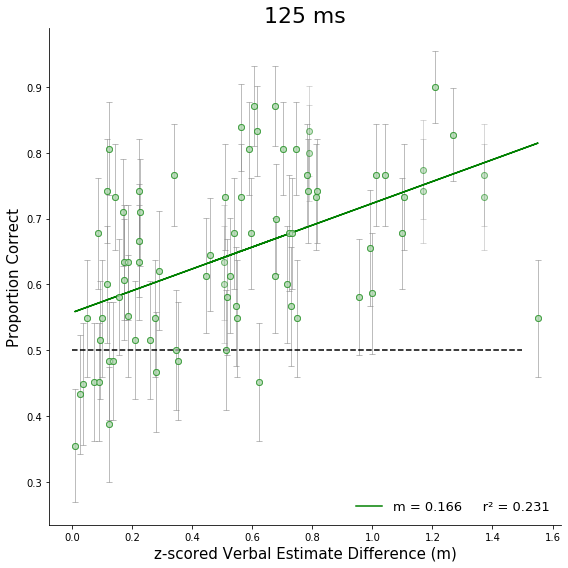

In [73]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


#run regression
VE_X_125 = np.array(np.abs(n_VE_estim_diff_125).reshape(-1,1))
VE_PC_125 = n_VE_accuracy_125
VE_PC_reg_125 = LinearRegression().fit(VE_X_125, VE_PC_125)

#Generated Predictions
PC_predicted_125 = VE_PC_reg_125.predict(VE_X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_125, VE_PC_125,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_125));


plt.plot(VE_X_125, VE_PC_125, 'o', color='green', alpha = 0.3);
plt.plot(VE_X_125, PC_predicted_125,color='green', label = 'm = ' + str(round(VE_PC_reg_125.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_125.score(VE_X_125, VE_PC_125)), 3)))
plt.xlabel("z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

plt.plot([0, 1.5], [0.5,0.5], '--', color='black')



#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_125.coef_))
print("b: {0}".format(VE_PC_reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_125.score(VE_X_125, VE_PC_125))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

plt.title('125 ms', fontsize=22)

fig.tight_layout()

plt.show();

m: [0.26017362]
b: 0.5760069840703224
R-squared:  0.4469091251461197


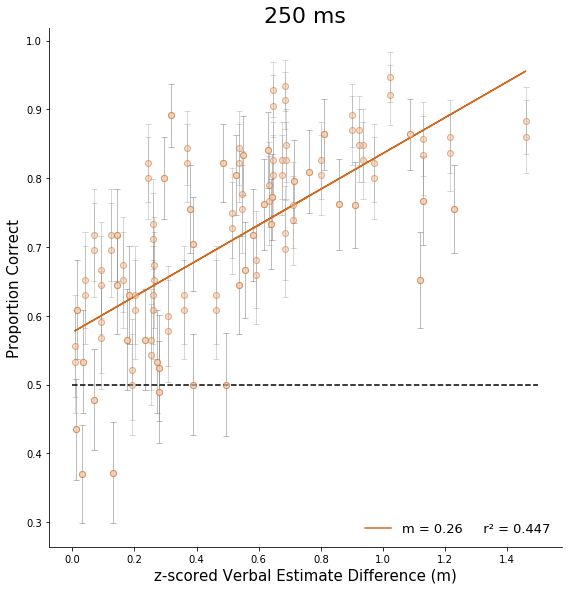

In [72]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


#run regression
VE_X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
VE_PC_250 = n_VE_accuracy_250
VE_PC_reg_250 = LinearRegression().fit(VE_X_250, VE_PC_250)

#Generated Predictions
PC_predicted_250 = VE_PC_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_250, VE_PC_250,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));


plt.plot(VE_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = 'm = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.xlabel("z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

plt.plot([0, 1.5], [0.5,0.5], '--', color='black')



#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_250.coef_))
print("b: {0}".format(VE_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_250.score(VE_X_250, VE_PC_250))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('250 ms', fontsize=22)


plt.show();

depth_discrimination_stimuli/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0-target.png depth_discrimination_stimuli/001056_2014-06-08_18-46-44_260595134347_rgbf000068-resize_0/001056_2014-06-08_18-46-44_260595134347_rgbf000068-resize_0-target.png
m: [0.26017362]
b: 0.5760069840703224
R-squared:  0.4469091251461197


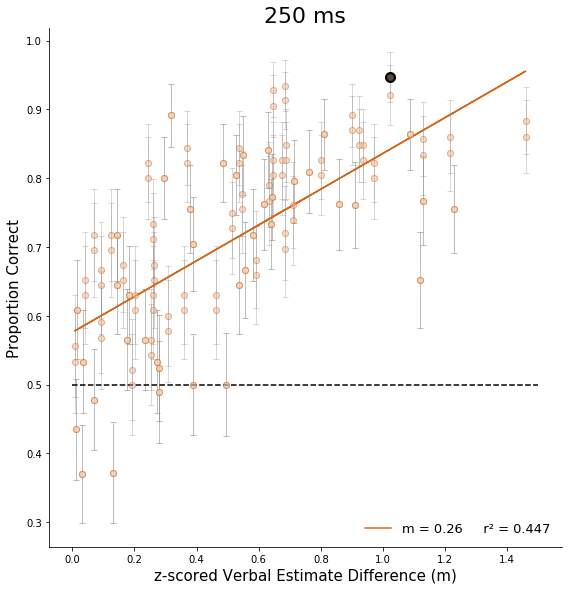

In [138]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


#run regression
VE_X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
VE_PC_250 = n_VE_accuracy_250
VE_PC_reg_250 = LinearRegression().fit(VE_X_250, VE_PC_250)

#Generated Predictions
PC_predicted_250 = VE_PC_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_250, VE_PC_250,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));


plt.plot(VE_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = 'm = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.xlabel("z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

plt.plot([0, 1.5], [0.5,0.5], '--', color='black')


i = 9
plt.plot(VE_X_250[i], VE_PC_250[i], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black", alpha=1)

print(n_stim[i], n_all_VE_discrim_performance[n_stim[i]]['stimulus_1'])



#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_250.coef_))
print("b: {0}".format(VE_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_250.score(VE_X_250, VE_PC_250))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('250 ms', fontsize=22)


plt.show();

m: [0.30408331]
b: 0.6146596170004615
R-squared:  0.4908771432845548


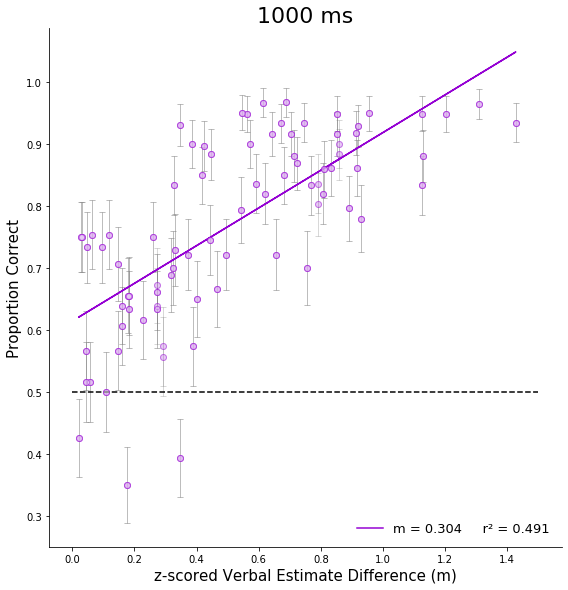

In [71]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


VE_X_1000 = np.array(np.abs(n_VE_estim_diff_1000).reshape(-1,1))
VE_PC_1000 = n_VE_accuracy_1000
VE_PC_reg_1000 = LinearRegression().fit(VE_X_1000, VE_PC_1000)

#Generated Predictions
PC_predicted_1000 = VE_PC_reg_1000.predict(VE_X_1000)
#Plot Our Actual and Predicted Values

r = np.sqrt(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)))

plt.errorbar(VE_X_1000, VE_PC_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_1000));
plt.plot(VE_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(VE_PC_reg_1000.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

plt.plot([0, 1.5], [0.5,0.5], '--', color='black')

# plt.plot(VE_X_1000[2], VE_PC_1000[2], 'o', color='black', alpha=1)

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_1000.coef_))
print("b: {0}".format(VE_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000))

plt.xlabel("z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)


# plt.title("1000 ms: Accuracy", fontsize = 20)

# plt.xticks(np.arange(-1,1.2, 0.2))
# plt.yticks(np.arange(-1,1.2, 0.2))

fig.tight_layout()

plt.title('1000 ms', fontsize=22)


plt.show();

Text(0, 0.5, 'Proportion Correct')

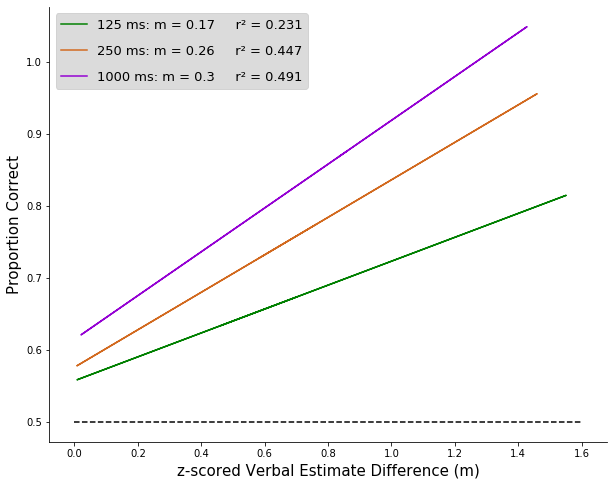

In [90]:
fig, ax = plt.subplots(figsize=[10,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.plot(VE_X_125, PC_predicted_125,color='green', label = '125 ms: m = ' + str(round(VE_PC_reg_125.coef_[0], 2))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_125.score(VE_X_125, VE_PC_125)), 3)))
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(VE_PC_reg_1000.coef_[0], 2))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 0, fontsize=13, labelspacing=1, frameon=True, facecolor='lightgray')

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')

plt.xlabel("z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

In [55]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_250, n_VE_accuracy_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_250)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_250, n_VE_accuracy_1000)
print(fvalue, pvalue)

34.96925956878319 7.114780599177742e-15
19.487424562054002 1.400005415424938e-05
68.7073123150687 3.5033238717017583e-15
16.083449504496215 7.60131131786465e-05


In [333]:
stats.pearsonr(n_VE_accuracy_250, n_VE_accuracy_125)

(0.5219466708245803, 2.7998773652545632e-12)

In [334]:
stats.pearsonr(n_VE_accuracy_125, n_VE_accuracy_1000)

(0.4610698029145073, 1.385504676367031e-09)

In [335]:
stats.pearsonr(n_VE_accuracy_250, n_VE_accuracy_1000)

(0.7735075965480653, 2.6087704378208774e-32)

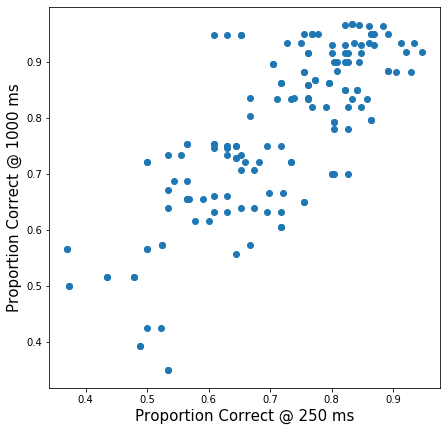

In [336]:
plt.figure(figsize=[7,7])
plt.xlabel('Proportion Correct @ 250 ms', fontsize=15)
plt.ylabel('Proportion Correct @ 1000 ms', fontsize=15)
plt.plot(n_VE_accuracy_250,n_VE_accuracy_1000, 'o' )

In [337]:
stats.pearsonr(n_VE_estim_diff_125, n_avg_RT_125)

(-0.12214379836112099, 0.1287626217098734)

m: [-83.75406064]
b: 1218.8851775838739
R-squared:  0.024225742949011586


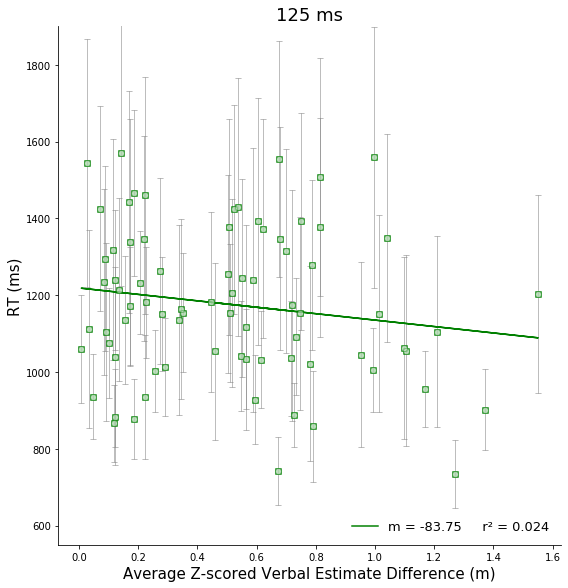

In [99]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_125 = np.array(np.abs(n_VE_estim_diff_125).reshape(-1,1))
y_125 = n_avg_RT_125
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_125));

plt.plot(X_125, y_125, 's', color='green', alpha = 0.3);
plt.plot(X_125, y_predicted_125,color='green', label = 'm = ' + str(round(reg_125.coef_[0], 2))
        + '     r' + get_super('2') + ' = '+ str(round(float(reg_125.score(X_125, y_125)), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

plt.ylim(550, 1900)

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('125 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

In [92]:
# n_avg_RT_250

In [93]:
stats.pearsonr(n_VE_estim_diff_250, n_avg_RT_250)

(-0.48686191124257533, 1.1598450351184185e-10)

m: [-133.32188088]
b: 904.1622739795257
R-squared:  0.20159573945921402


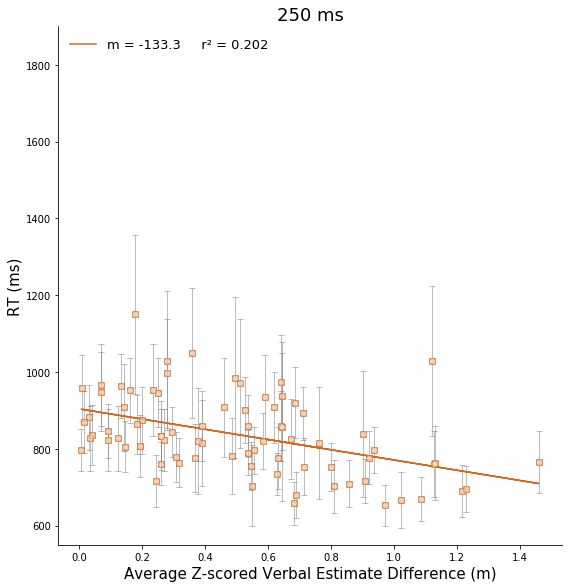

In [101]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
y_250 = n_avg_RT_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_250));

plt.plot(X_250, y_250, 's', color='chocolate', alpha = 0.3);
plt.plot(X_250, y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 1))
        + '     r' + get_super('2') + ' = '+ str(round(float(reg_250.score(X_250, y_250)), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

plt.ylim(550, 1900)


legend = plt.legend(loc = 2, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

# plt.xticks(np.arange(0.15,1.2, 0.2))
# plt.yticks(np.arange(6.7,7.3, .1))

plt.title('250 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

In [345]:
stats.pearsonr(n_VE_estim_diff_1000, n_avg_RT_1000)

(-0.4765614495223037, 3.2016267829093836e-10)

m: [-150.43823441]
b: 1004.154998852782
R-squared:  0.22262424340607956


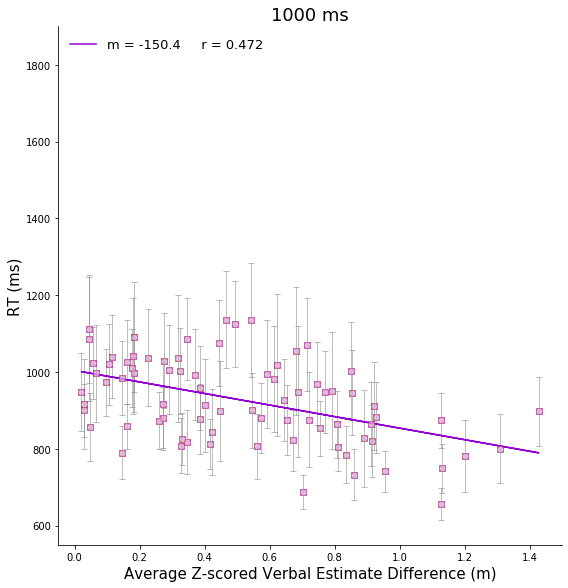

In [103]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_1000 = np.array(np.abs(n_VE_estim_diff_1000).reshape(-1,1))
y_1000 = n_avg_RT_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_1000));

r = np.sqrt(float(reg_1000.score(X_1000, y_1000)))

plt.plot(X_1000, y_1000, 's', color='darkviolet', alpha = 0.3);
plt.plot(X_1000, y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 1))
        + '     r = '+ str(round(float(r), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)
plt.ylim(550, 1900)


legend = plt.legend(loc = 2, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

# plt.yticks(np.arange(6.7,7.3, .1))

plt.title('1000 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

In [65]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_250, n_avg_RT_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_250)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_avg_RT_250, n_avg_RT_1000)
print(fvalue, pvalue)

236.14215689754425 1.6700248985927175e-71
364.29792312656974 3.0023414514393285e-54
191.63401168541063 2.9088688511805546e-34
55.689197722798745 8.626399692354293e-13


# Regressor: Difference between verbal judgements divided by joint variance 

In [220]:
print('125 ms: Correlation between VE discrimination accuracy and difference between normalized verbal judgements divided by joint variance ')
stats.pearsonr(n_VE_accuracy_125, n_JV_125)

125 ms: Correlation between VE discrimination accuracy and difference between normalized verbal judgements divided by joint variance 


(0.4800125213934738, 2.286951287441381e-10)

In [221]:
print('250 ms: Correlation between VE discrimination accuracy and difference between normalized verbal judgements divided by joint variance ')
stats.pearsonr(n_VE_accuracy_250, n_JV_250)

250 ms: Correlation between VE discrimination accuracy and difference between normalized verbal judgements divided by joint variance 


(0.7151779152170161, 9.872315185291696e-26)

In [222]:
print('1000 ms: Correlation between VE discrimination accuracy and difference between verbal judgements divided by joint variance ')
stats.pearsonr(n_VE_accuracy_1000, n_JV_1000)

1000 ms: Correlation between VE discrimination accuracy and difference between verbal judgements divided by joint variance 


(0.7361426630591454, 6.787235502258777e-28)

m: [0.17336532]
b: 0.5595762077891854
R-squared:  0.23041202069452008


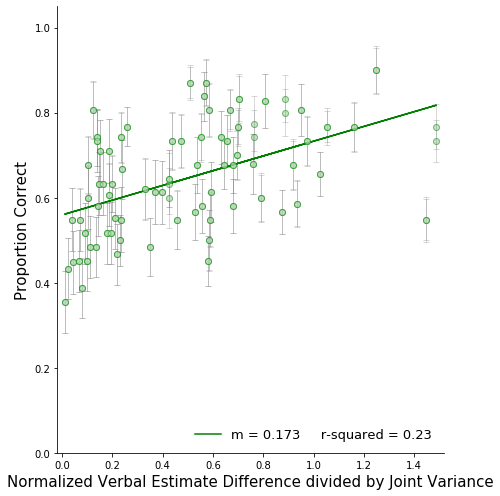

In [223]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
JV_X_125 = np.array(n_JV_125).reshape(-1,1)
VE_PC_125 = n_VE_accuracy_125
JV_PC_reg_125 = LinearRegression().fit(JV_X_125, VE_PC_125)

#Generated Predictions
JV_PC_predicted_125 = JV_PC_reg_125.predict(JV_X_125)
#Plot Our Actual and Predicted Values

plt.errorbar(JV_X_125, VE_PC_125, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));
plt.plot(JV_X_125, VE_PC_125, 'o', color='green', alpha = 0.3);
plt.plot(JV_X_125, JV_PC_predicted_125,color='green', label = 'm = ' + str(round(JV_PC_reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_125.score(JV_X_125, VE_PC_125)), 3)))
# plt.xlabel("Diff b/w normalized verbal judgements divided by joint variance", fontsize = 15)
plt.xlabel("Normalized Verbal Estimate Difference divided by Joint Variance", fontsize = 15)

plt.ylabel("Proportion Correct", fontsize = 15)

plt.ylim((0,1.05))
plt.xticks(np.arange(0,1.8, 0.2))
plt.yticks(np.arange(0,1.2, 0.2))
plt.margins(x=0.02)


#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_125.coef_))
print("b: {0}".format(JV_PC_reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_125.score(JV_X_125, VE_PC_125))

# plt.plot([-0.6, 0.9], [0.5,0.5], '--', color='black')


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

# plt.plot(JV_X_250[10], VE_PC_250[10], 'o', color='black', alpha=1)


fig.tight_layout()

plt.show();

m: [0.27368456]
b: 0.5733977739334886
R-squared:  0.5114794504141573


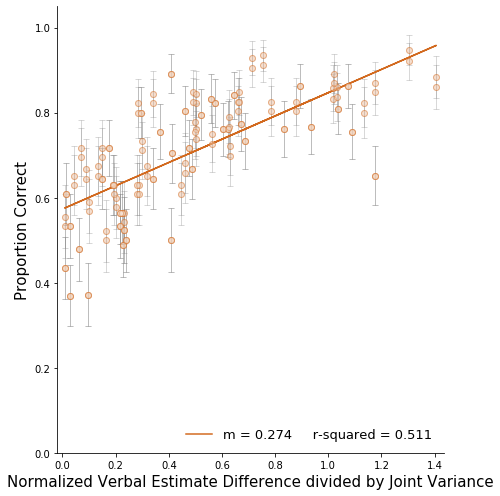

In [224]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
JV_X_250 = np.array(n_JV_250).reshape(-1,1)
VE_PC_250 = n_VE_accuracy_250
JV_PC_reg_250 = LinearRegression().fit(JV_X_250, VE_PC_250)

#Generated Predictions
JV_PC_predicted_250 = JV_PC_reg_250.predict(JV_X_250)
#Plot Our Actual and Predicted Values

plt.errorbar(JV_X_250, VE_PC_250, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));
plt.plot(JV_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(JV_X_250, JV_PC_predicted_250,color='chocolate', label = 'm = ' + str(round(JV_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_250.score(JV_X_250, VE_PC_250)), 3)))
# plt.xlabel("Diff b/w normalized verbal judgements divided by joint variance", fontsize = 15)
plt.xlabel("Normalized Verbal Estimate Difference divided by Joint Variance", fontsize = 15)

plt.ylabel("Proportion Correct", fontsize = 15)

plt.ylim((0,1.05))
plt.xticks(np.arange(0,1.8, 0.2))
plt.yticks(np.arange(0,1.2, 0.2))
plt.margins(x=0.02)


#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_250.coef_))
print("b: {0}".format(JV_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_250.score(JV_X_250, VE_PC_250))

# plt.plot([-0.6, 0.9], [0.5,0.5], '--', color='black')


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

# plt.plot(JV_X_250[10], VE_PC_250[10], 'o', color='black', alpha=1)


fig.tight_layout()

plt.show();


m: [0.31957772]
b: 0.6111521113634991
R-squared:  0.5419060203758105


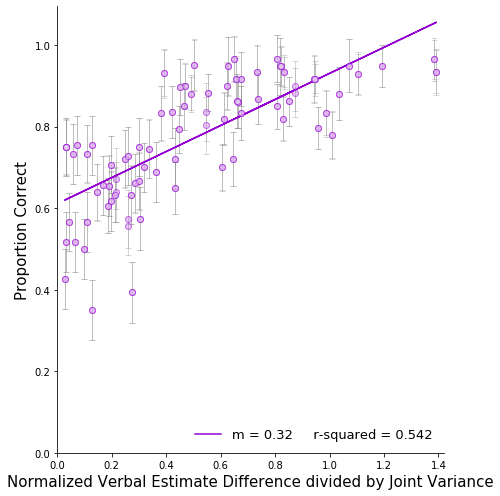

In [225]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
JV_X_1000 = np.array(n_JV_1000).reshape(-1,1)
VE_PC_1000 = n_VE_accuracy_1000
JV_PC_reg_1000 = LinearRegression().fit(JV_X_1000, VE_PC_1000)

#Generated Predictions
JV_PC_predicted_1000 = JV_PC_reg_1000.predict(JV_X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(JV_X_1000, VE_PC_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));
plt.plot(JV_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3); 
plt.plot(JV_X_1000, JV_PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(JV_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000)), 3)))
# plt.xlabel("Diff b/w normalized verbal judgements divided by joint variance", fontsize = 15)
plt.xlabel("Normalized Verbal Estimate Difference divided by Joint Variance", fontsize = 15)

plt.ylabel("Proportion Correct", fontsize = 15)

plt.xticks(np.arange(0,1.8, 0.2))
plt.yticks(np.arange(0,1.2, 0.2))
plt.margins(x=0.02)


#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_1000.coef_))
print("b: {0}".format(JV_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000))

# plt.plot([-0.6, 0.9], [0.5,0.5], '--', color='black')


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)


# plt.plot(JV_X_1000[10], VE_PC_1000[10], 'o', color='black', alpha=3)


fig.tight_layout()

plt.show();



(0.9190586115715246, 3.720107069248669e-64)


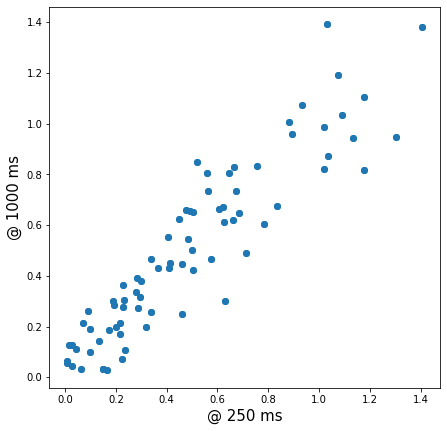

In [226]:
print(stats.pearsonr(n_JV_250, n_JV_1000))
plt.figure(figsize=[7,7])
plt.xlabel('@ 250 ms', fontsize=15)
plt.ylabel('@ 1000 ms', fontsize=15)
plt.plot(n_JV_250,n_JV_1000, 'o' )

In [227]:
print('125 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance ')
stats.pearsonr(n_avg_RT_125, n_JV_125)

125 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance 


(-0.14772278129027466, 0.06572009116767603)

In [228]:
print('250 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance ')
stats.pearsonr(n_avg_RT_250, n_JV_250)

250 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance 


(-0.4449335106659815, 5.907400188640517e-09)

In [229]:
print('1000 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance ')
stats.pearsonr(n_avg_RT_1000, n_JV_1000)

1000 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance 


(-0.5093904084769261, 1.1148219629561808e-11)

m: [-83.13879137]
b: 1215.6461247185505
R-squared:  0.02182202011213441


Text(0.5, 1.0, '125 ms: RT')

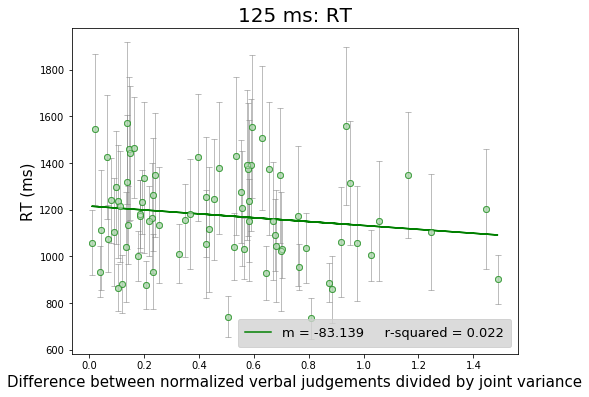

In [230]:
#run regression
plt.figure(figsize=[8,6])
JV_X_125 = np.array(n_JV_125).reshape(-1,1)
VE_PC_125 = n_avg_RT_125
JV_PC_reg_125 = LinearRegression().fit(JV_X_125, VE_PC_125)

#Generated Predictions
JV_PC_predicted_125 = JV_PC_reg_125.predict(JV_X_125)
#Plot Our Actual and Predicted Values

plt.errorbar(JV_X_125, VE_PC_125, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_125));


plt.plot(JV_X_125, VE_PC_125, 'o', color='green', alpha = 0.3);
plt.plot(JV_X_125, JV_PC_predicted_125,color='green', label = 'm = ' + str(round(JV_PC_reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_125.score(JV_X_125, VE_PC_125)), 3)))
plt.xlabel("Difference between normalized verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_125.coef_))
print("b: {0}".format(JV_PC_reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_125.score(JV_X_125, VE_PC_125))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("125 ms: RT", fontsize = 20)

m: [-129.90876121]
b: 900.4458475155232
R-squared:  0.19796582891355508


Text(0.5, 1.0, '250 ms: RT')

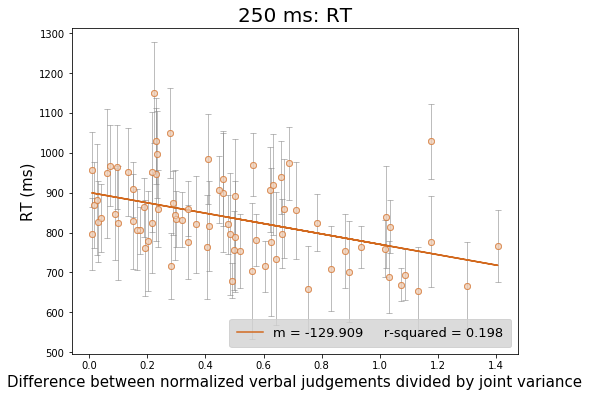

In [231]:
#run regression
plt.figure(figsize=[8,6])
JV_X_250 = np.array(n_JV_250).reshape(-1,1)
VE_PC_250 = n_avg_RT_250
JV_PC_reg_250 = LinearRegression().fit(JV_X_250, VE_PC_250)

#Generated Predictions
JV_PC_predicted_250 = JV_PC_reg_250.predict(JV_X_250)
#Plot Our Actual and Predicted Values

plt.errorbar(JV_X_250, VE_PC_250, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_1000));


plt.plot(JV_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(JV_X_250, JV_PC_predicted_250,color='chocolate', label = 'm = ' + str(round(JV_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_250.score(JV_X_250, VE_PC_250)), 3)))
plt.xlabel("Difference between normalized verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_250.coef_))
print("b: {0}".format(JV_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_250.score(JV_X_250, VE_PC_250))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("250 ms: RT", fontsize = 20)

m: [-162.45425638]
b: 1008.0745129455323
R-squared:  0.2594785882482895


Text(0.5, 1.0, '1000 ms: RT')

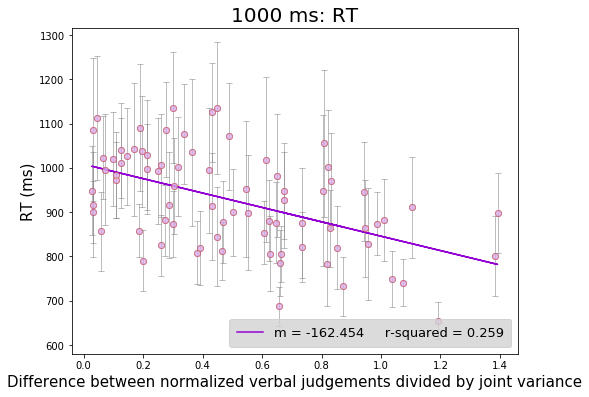

In [232]:
#run regression
plt.figure(figsize=[8,6])
JV_X_1000 = np.array(n_JV_1000).reshape(-1,1)
VE_PC_1000 = n_avg_RT_1000
JV_PC_reg_1000 = LinearRegression().fit(JV_X_1000, VE_PC_1000)

#Generated Predictions
JV_PC_predicted_1000 = JV_PC_reg_1000.predict(JV_X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(JV_X_1000, VE_PC_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_1000));

plt.plot(JV_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(JV_X_1000, JV_PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(JV_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000)), 3)))
plt.xlabel("Difference between normalized verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_1000.coef_))
print("b: {0}".format(JV_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("1000 ms: RT", fontsize = 20)

# Discrim x VE 


In [53]:
_dir = ''
rawVE_125_data = pd.read_csv(_dir + '/raw_125_data.csv')
rawVE_250_data = pd.read_csv(_dir + '/raw_250_data.csv')
rawVE_1000_data = pd.read_csv(_dir + '/raw_1000_data.csv')



In [35]:
targetimgs_discrim = []

for stim in n_stim:
    targetimgs_discrim.append(stim.split('/')[1] + '/' + stim.split('/')[-1])
    
targetimgs_discrim[0], len(targetimgs_discrim)

In [36]:
VE_250_Performance = {}
# loop through discrimination target images
for im0 in targetimgs_discrim:
    performance = []
    # loop through all participants
    for subjID in rawVE_250_data.subjID.unique():
        # filter to just the subjects data df
        subjdf_250 = rawVE_250_data.loc[rawVE_250_data['subjID'] == subjID]
        # extract stimuli and depth estimate list for the participant
        particip_VE_stim_250 = list(subjdf_250['stimulus'])
        particip_VE_y_250 = list(subjdf_250['depth_estimate'])
        # convert stim to just the targetimg part of the path
        particip_VE_targetimgs_250 = []
        for stim in particip_VE_stim_250:
            particip_VE_targetimgs_250.append(stim.split('/')[1] + '/' + stim.split('/')[-1])
        
        try:
            # index for that image in the verbal judgement data 
            im0_VE_index_250 = particip_VE_targetimgs_250.index(im0)
            # depth estimate for this image at 250 ms
            im0_particip_VE_y_250 = particip_VE_y_250[im0_VE_index_250]

            key = 'depth_discrimination_stimuli/' + im0

            im1 = n_all_VE_discrim_performance[key]['stimulus_1'][29:]
            # index for that image in the verbal judgement data 
            im1_VE_index_250 = particip_VE_targetimgs_250.index(im1)
            # depth estimate for this image at 250 ms
            im1_particip_VE_y_250 = particip_VE_y_250[im1_VE_index_250]
            
            if im0_particip_VE_y_250 < im1_particip_VE_y_250:
                p_ans = im0.split('/')[-1]
            else:
                p_ans = im1.split('/')[-1]
            try:
                answerkey_answer = n_VE_answerkey_250[key]['answer']
            except:
                answerkey_answer = n_VE_answerkey_250['depth_discrimination_stimuli/' + im1]['answer']
            if p_ans == answerkey_answer:
                trial_acc = 0 # CORRECT
                performance.append(trial_acc)
            else:
                trial_acc = 1 # INCORRECT
                performance.append(trial_acc)
            
        except:
            pass
    VE_250_Performance[im0] = performance
        


In [ ]:
print(VE_250_Performance['001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png'])


In [57]:
p = '/Users/prachi/Documents/depth_duration/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/'

with open(p + 'VE_250_Performance.pickle', 'wb') as handle:
    pickle.dump(VE_250_Performance, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [37]:
# Python code to count the number of occurrences
def countX(lst, x):
    return lst.count(x)

VE_250_PC = {}

for key in VE_250_Performance:
    performance = VE_250_Performance[key]
    correct_count = countX(performance, 0)
    incorrect_count = countX(performance, 1)
    total = len(performance)
    pc = correct_count/total
    VE_250_PC['depth_discrimination_stimuli/' + key] = pc
    
VE_250_PC['depth_discrimination_stimuli/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png'] 


In [38]:
Discrim_VE_PC_250 = {}
all_stim_250 = []
all_VE_PC_250 = []
all_Discrim_VE_PC_250 = []

for key in VE_250_PC:
    im_VE_PC = VE_250_PC[key]
    im_Discrim_PC = n_all_VE_discrim_performance[key]['accuracy_250'][0]
    Discrim_VE_PC_250[key] = [im_VE_PC, im_Discrim_PC]
    
    all_stim_250.append(key)
    all_VE_PC_250.append(im_VE_PC)
    all_Discrim_VE_PC_250.append(im_Discrim_PC)
    
Discrim_VE_PC_250['depth_discrimination_stimuli/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png']

In [39]:
all_stim_250[0], all_VE_PC_250[0], all_Discrim_VE_PC_250[0]

In [40]:
# all_stim_250

In [41]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_250 = np.array(all_VE_PC_250).reshape(-1,1)
y_250 = np.array(all_Discrim_VE_PC_250)
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='chocolate', alpha = 0.7);

r = np.sqrt(reg_250.score(X_250, y_250))

plt.plot(X_250,y_predicted_250,color='chocolate', label = 'y = ' + str(round(reg_250.coef_[0], 3)) + 'x + ' +  str(round(reg_250.intercept_, 3))
         + '     r' + '=' +  str(round(float(r), 3)))

x_perfacc = np.arange(0.1 ,1.1, 0.1)
plt.plot(x_perfacc, x_perfacc, color = 'black',linestyle='--')  # solid

legend = plt.legend(loc = 0, fontsize = 13, labelspacing = 1, frameon=False)

plt.xlabel('Verbal Estimate Percent Correct', fontsize=15)
plt.ylabel('Discrimination Percent Correct', fontsize=15)

plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.yticks(np.arange(0.1, 1.1, 0.1))



#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

In [58]:
VE_1000_Performance = {}
# loop through discrimination target images
for im0 in targetimgs_discrim:
    performance = []
    # loop through all participants
    for subjID in rawVE_1000_data.subjID.unique():
        # filter to just the subjects data df
        subjdf_1000 = rawVE_1000_data.loc[rawVE_1000_data['subjID'] == subjID]
        # extract stimuli and depth estimate list for the participant
        particip_VE_stim_1000 = list(subjdf_1000['stimulus'])
        particip_VE_y_1000 = list(subjdf_1000['depth_estimate'])
        # convert stim to just the targetimg part of the path
        particip_VE_targetimgs_1000 = []
        for stim in particip_VE_stim_1000:
            particip_VE_targetimgs_1000.append(stim.split('/')[1] + '/' + stim.split('/')[-1])
        
        try:
            # index for that image in the verbal judgement data 
            im0_VE_index_1000 = particip_VE_targetimgs_1000.index(im0)
            # depth estimate for this image at 250 ms
            im0_particip_VE_y_1000 = particip_VE_y_1000[im0_VE_index_1000]

            key = 'depth_discrimination_stimuli/' + im0

            im1 = n_all_VE_discrim_performance[key]['stimulus_1'][29:]
            # index for that image in the verbal judgement data 
            im1_VE_index_1000 = particip_VE_targetimgs_1000.index(im1)
            # depth estimate for this image at 1000 ms
            im1_particip_VE_y_1000 = particip_VE_y_1000[im1_VE_index_1000]
            
            if im0_particip_VE_y_1000 < im1_particip_VE_y_1000:
                p_ans = im0.split('/')[-1]
            else:
                p_ans = im1.split('/')[-1]
            try:
                answerkey_answer = n_VE_answerkey_1000[key]['answer']
            except:
                answerkey_answer = n_VE_answerkey_1000['depth_discrimination_stimuli/' + im1]['answer']
            if p_ans == answerkey_answer:
                trial_acc = 0 # CORRECT
                performance.append(trial_acc)
            else:
                trial_acc = 1 # INCORRECT
                performance.append(trial_acc)
            
        except:
            pass
    VE_1000_Performance[im0] = performance
        


In [59]:
p = '/Users/prachi/Documents/depth_duration/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/'
with open(p + 'VE_1000_Performance.pickle', 'wb') as handle:
    pickle.dump(VE_1000_Performance, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [140]:
# print(VE_250_Performance['001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png'])
# VE_1000_Performance['001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png']


In [42]:
# Python code to count the number of occurrences
def countX(lst, x):
    return lst.count(x)

VE_1000_PC = {}

for key in VE_1000_Performance:
    performance = VE_1000_Performance[key]
    correct_count = countX(performance, 0)
    incorrect_count = countX(performance, 1)
    total = len(performance)
    pc = correct_count/total
    VE_1000_PC['depth_discrimination_stimuli/' + key] = pc
    
VE_1000_PC['depth_discrimination_stimuli/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png'] 


In [43]:
Discrim_VE_PC_1000 = {}
all_stim_1000 = []
all_VE_PC_1000 = []
all_Discrim_VE_PC_1000 = []

for key in VE_1000_PC:
    im_VE_PC = VE_1000_PC[key]
    im_Discrim_PC = n_all_VE_discrim_performance[key]['accuracy_1000'][0]
    Discrim_VE_PC_1000[key] = [im_VE_PC, im_Discrim_PC]
    
    all_stim_1000.append(key)
    all_VE_PC_1000.append(im_VE_PC)
    all_Discrim_VE_PC_1000.append(im_Discrim_PC)
    
Discrim_VE_PC_1000['depth_discrimination_stimuli/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png']

In [44]:
all_stim_1000[0], all_VE_PC_1000[0], all_Discrim_VE_PC_1000[0]

In [45]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_1000 = np.array(all_VE_PC_1000).reshape(-1,1)
y_1000 = np.array(all_Discrim_VE_PC_1000)
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='darkviolet', alpha = 0.7);

r = np.sqrt(reg_1000.score(X_1000, y_1000))

plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'y = ' + str(round(reg_1000.coef_[0], 3)) + 'x + ' +  str(round(reg_1000.intercept_, 3))
         + '     r' + '=' +  str(round(float(r), 3)))

x_perfacc = np.arange(0.1 ,1.1, 0.1)
plt.plot(x_perfacc, x_perfacc, color = 'black',linestyle='--')  # solid

legend = plt.legend(loc = 0, fontsize = 13, labelspacing = 1, frameon=False)

plt.xlabel('Verbal Estimate Percent Correct', fontsize=15)
plt.ylabel('Discrimination Percent Correct', fontsize=15)

plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.yticks(np.arange(0.1, 1.1, 0.1))

#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))